In [1]:
from dotenv import load_dotenv

load_dotenv()

True

In [2]:
from langchain_chroma import Chroma
from langchain_openai import OpenAIEmbeddings

embedding_function = OpenAIEmbeddings(model='text-embedding-3-large')

vector_store = Chroma(
    embedding_function=embedding_function,
    collection_name="income_tax_collection",
    persist_directory="./income_tax_collection"
)

retriever = vector_store.as_retriever(search_kwargs={"k": 3})

In [3]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph

class AgentState(TypedDict):
    query: str
    context: list
    answer: str

graph_builder = StateGraph(AgentState)

In [4]:
def retrieve(state : AgentState):
  query = state['query']
  docs = retriever.invoke(query)
  return {'context': docs}

In [5]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o', temperature=0)

In [6]:
from langsmith import Client
from langchain_core.output_parsers import StrOutputParser
client = Client()
generate_prompt = client.pull_prompt("rlm/rag-prompt", include_model=True)
generate_llm = ChatOpenAI(model='gpt-4o', max_completion_tokens=100)
def generate(state: AgentState):
  context = state['context']
  query = state['query']
  rag_chain = generate_prompt | generate_llm | StrOutputParser()
  response = rag_chain.invoke({'question': query, 'context': context})
  return {'answer' : response}

In [7]:
from typing import Literal

# 문서 관련성 평가 프롬프트 불러오기 (doc_relevance_prompt 변수에 저장)
client = Client()
doc_relevance_prompt = client.pull_prompt("langchain-ai/rag-document-relevance", include_model=True)

def check_doc_relevance(state: AgentState) -> Literal['relevant', 'irrelevant']:
    query = state["query"]
    context = state['context']
    doc_relevance_chain = doc_relevance_prompt | llm
    response = doc_relevance_chain.invoke({'question': query, 'documents': context})
    if response['Score'] == 1:
        return 'relevant'

    return 'irrelevant'

In [8]:
from langchain_core.prompts import PromptTemplate
from langchain_core.output_parsers import StrOutputParser
dictionary = ['사람과 관련된 표현자 -> 거주자']

rewrite_prompt = PromptTemplate.from_template("""
사용자의 질문을 보고, 웹 검색에 용이하게 사용자의 질문을 수정해주세요.
질문 : {query} 
""")

def rewrite(state: AgentState):
    query = state['query']
    rewrite_chain = rewrite_prompt | llm | StrOutputParser()
    response = rewrite_chain.invoke({'query': query})
    return {'query': response}

In [9]:
from langchain_community.tools import TavilySearchResults

tavily_search_tool = TavilySearchResults(
  max_results=3,
  search_depth="advanced",
  include_answer=True,
  include_raw_content=True,
  include_images=True
)

def web_search(state: AgentState):
    query = state["query"]
    results = tavily_search_tool.invoke(query)
    return {'context': results}

C:\Users\jo\AppData\Local\Temp\ipykernel_26060\2396431041.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the `langchain-tavily package and should be used instead. To use it run `pip install -U `langchain-tavily` and import as `from `langchain_tavily import TavilySearch``.
  tavily_search_tool = TavilySearchResults(


In [10]:
graph_builder.add_node('retrieve', retrieve)
graph_builder.add_node('generate', generate)
graph_builder.add_node('rewrite', rewrite)
graph_builder.add_node('web_search', web_search)

In [11]:
from langgraph.graph import START, END

graph_builder.add_edge(START, 'retrieve')
graph_builder.add_conditional_edges(
    'retrieve',
    check_doc_relevance,
    {
        'relevant': 'generate',
        'irrelevant': 'rewrite'
    }
)
graph_builder.add_edge('rewrite', 'web_search')
graph_builder.add_edge('web_search', 'generate')
graph_builder.add_edge('generate', END)

In [12]:
graph = graph_builder.compile()

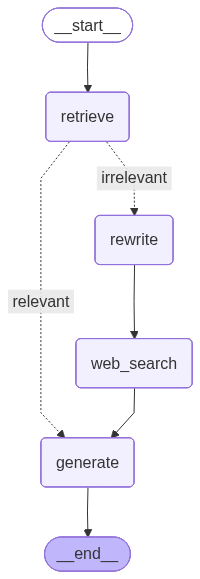

In [14]:
from IPython.display import Image, display

png_bytes = graph.get_graph().draw_mermaid_png()
display(Image(data=png_bytes))

In [ ]:
initial_state = {'query' : '연봉 5천만원 거주지의 소득세는 얼마인가요?'} 